In [267]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process
import load_data
import pre_processing_utils as ppu
from itertools import cycle

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, label_binarize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

#Model scoring 
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, confusion_matrix, confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score, roc_curve, auc

In [41]:
import importlib
importlib.reload(ppu)

<module 'pre_processing_utils' from '/Users/alexmihalache/Library/CloudStorage/OneDrive-Personal/BrainStation/Capstone/Capstone Project - FAWSL Analysis/pre_processing_utils.py'>

In [4]:
# load data

xt, xt_test, vaep, vaep_test, games, games_test, players, players_test, target_players = load_data.load_data()

In [39]:
modeling_train_df = vaep.copy()
modeling_test_df = vaep_test.copy()
modeling_xt_train_df = xt.copy()
modeling_xt_test_df = xt_test.copy()


## Classification Features

In [62]:
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

## Identifying transfers

In [ ]:
target_players.head()

,player_id,player_name,minutes_played
0,24239,Jemma Elizabeth Purfield,2016
1,15579,Inessa Kaagman,2015
2,5076,Emily Louise van Egmond,1940
3,5074,Shelina Laura Zadorsky,1930
4,31534,Ella Toone,1887


In [ ]:
players[players['player_id']==24239].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
360,19810,966,24239,Jemma Elizabeth Purfield,NaN,23,True,6,Left Back,96


In [ ]:
players_test[players_test['player_id']==24239].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
371,3775636,973,24239,Jemma Elizabeth Purfield,NaN,23,True,6,Left Back,103


## VAEP Approach

## Modeling 

**Approach to modeling:**

1. Pick a player to replace in a team
2. Get the top players in their cluster as potential replacements 
3. Fit a model for each of the scouted players 
    - use only that player's data to fit the model
    - the models will predict their next location and the action they take 
    - the parameters in the model should cover the player characteristics and team characteristics. For example, the 5 past moves cover what the team does, and how then the player reacts to those. The player action is the predicted target 

**Model validation and testing approach:**

- Of the scouted players, find those that have undergone a transfer in season 3 in our data set - use season 3 data to test our predictions. 
- Score the model based on the real data from their new team


**Models to train and test:**

- Baseline model for logistic regression for next action and end pitch location
- Random Forest classifier for end pitch location and next action 
- xGBoost classifier for end pitch location and next action 
- Random Forest regressor for end_x and end_y location 
- xGBoost regressor for enx_x and end_y location

## Grid Search with Cross-Validation

## Scoring output

**Create a class that:**

1. Takes in a player id 
2. Slices the dataset for this player
3. Clusters most similar players 
4. Take the top 3 players 
5. Slices the datasets for each player
6. Fits a model for each 
7. Run a prediction based on the original player dataset
8. Scores the results 

add in:

kNN
SVM
DT
Random Forest
xGBoost

with a cv 5

Run it for End-zone 
Run it for Next Action
Run it for VAEP Regression 
Run it for xT regression (build the dataset)

add in kbest
add in PCA

In [7]:
from tempfile import mkdtemp
cachedir = mkdtemp()

**Approach:**

- Try a few manual models - with different feature combinations, mainly focusing on regularisation, learning rate and depth of trees
- Try to identify ranges for the hyperparams 
- Run a gridsearch in the ranges identified for the features identified
- Review results and if needed re-run manual checks
- Re-do gridsearch with new params

# Regression - Team - VAEP

In [388]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'vaep_value')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer for GridSearchCV
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [63]:
print('*** Random Forest Regressor - Depth 5 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 10 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 15 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=15))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 10 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 15 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=15))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 5 ***
Random Forest Train Score:  0.8160415586816594
Random Forest Test Score:  0.7333054326388806
 
*** Random Forest Regressor - Depth 10 ***
Random Forest Train Score:  0.9252032890968886
Random Forest Test Score:  0.7696565710141716
 
*** Random Forest Regressor - Depth 15 ***
Random Forest Train Score:  0.9572404369298733
Random Forest Test Score:  0.770458041532036
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9773771604640682
XGB Regressor Test Score:  0.7774353046416602
 
*** xGBoost Regressor - Depth 10 ***
XGB Regressor Train Score:  0.9996424598218189
XGB Regressor Test Score:  0.7722946268899323
 
*** xGBoost Regressor - Depth 15 ***
XGB Regressor Train Score:  0.9997710007647611
XGB Regressor Test Score:  0.7744886387854324
 


In [64]:
print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 20 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=20))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 25 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=25))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 2 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=2))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 3 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=3))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9614962650539055
Random Forest Test Score:  0.7760280656011058
 
*** Random Forest Regressor - Depth 20 ***
Random Forest Train Score:  0.9645378642352276
Random Forest Test Score:  0.7728209532690797
 
*** Random Forest Regressor - Depth 25 ***
Random Forest Train Score:  0.9710229219176514
Random Forest Test Score:  0.7733866093735826
 
*** xGBoost Regressor - Depth 2 ***
XGB Regressor Train Score:  0.8462431898067477
XGB Regressor Test Score:  0.7393302816944547
 
*** xGBoost Regressor - Depth 3 ***
XGB Regressor Train Score:  0.9242034953688028
XGB Regressor Test Score:  0.769936203996455
 


In [65]:
# Define a parameter grid
param_grid = [
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBRegressor(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2)
fitted_grid = grid.fit(X_train, y_train)

# fitted_grid.best_estimator_
# fitted_grid.score(X_test, y_test)

Fitting 5 folds for each of 91 candidates, totalling 455 fits
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   5.5s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=sqrt, model__n_estimators=80; total time=   2.8s
[CV] END model=RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=1), model__

In [67]:
grid_search_results = pd.DataFrame(fitted_grid.cv_results_)
grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
83,4.399968,0.042012,0.032239,0.000499,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.3,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.435324,-0.058706,0.235063,0.375228,0.399281,0.277238,0.181177,1
74,4.374043,0.068614,0.033129,0.001972,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.430918,-0.001321,0.221700,0.267397,0.375161,0.258771,0.149852,2
73,3.211093,0.032683,0.030821,0.002246,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.420600,0.212421,0.138343,0.122829,0.291122,0.237063,0.109554,3
75,5.688128,0.137392,0.033125,0.001207,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.1,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.430948,-0.143982,0.245534,0.256299,0.393311,0.236422,0.203784,4
84,5.655732,0.085976,0.032792,0.002939,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.3,0.1,"{'model': XGBRegressor(base_score=None, booste...",0.404752,-0.167093,0.231453,0.184793,0.389565,0.208694,0.206619,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4.329026,0.062792,0.031671,0.001793,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-25.881851,-47.209353,-27.040913,-16.651056,-20.219825,-27.400600,10.601310,87
67,3.279602,0.104560,0.031089,0.000804,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-25.889016,-47.184387,-27.089479,-16.645945,-20.237177,-27.409201,10.590153,88
70,3.260674,0.093230,0.031827,0.001571,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-25.889016,-47.184387,-27.108559,-16.628963,-20.237177,-27.409620,10.593496,89
65,4.338018,0.036118,0.032612,0.000850,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.1,"{'model': XGBRegressor(base_score=None, booste...",-25.875187,-47.395441,-26.959851,-16.655387,-20.211795,-27.419532,10.671940,90


In [66]:
print(fitted_grid.best_estimator_)
fitted_grid.score(X_test, y_test)

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['start_x', 'start_y',
                                                   'end_x', 'end_y', 'x_dif',
                                                   'y_dif', 'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-2_x_di...
                              importance_type=None, interaction_constraints=''

0.22566229633244372

- Max_features sqrt has a big impact on accuracy - therefore, none or auto are the best options 
- for xgb reg_alpha helps with regularisation - small increments above 1 have a big impact in reducing train scores, without reducing test scores by much

In [79]:
print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=150, oob_score=True, n_jobs=-1, random_state=1))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')


print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9605924868379286
Random Forest Test Score:  0.7727033214856343
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9773771604640682
XGB Regressor Test Score:  0.7774353046416602
 


Lower gamma, and introduce alpha for regularisation - What does lower gamma mean, and what would regularisation do

#### Grid Search - Iteration 2

In [147]:
# Define a parameter grid
param_grid = [
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_estimators=120, n_jobs=-1)],
        'model__max_depth': list(range(10, 17, 1)),
        'model__max_features': [None, 'auto']},
    
     {
        'model': [xgb.XGBRegressor(random_state=1, gamma=0.01)],
        'model__max_depth': list(range(4, 8, 1)),
        'model__eta': [0.1, 0.3],
        'model__reg_alpha': [1, 1.1, 1.2]
        },

]

# Instantiate a gridsearch
grid = GridSearchCV(estimator, param_grid, cv = 5, verbose = 2)
fitted_grid = grid.fit(X_train, y_train)

# fitted_grid.best_estimator_
# fitted_grid.score(X_test, y_test)

Fitting 5 folds for each of 38 candidates, totalling 190 fits
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  24.8s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  22.7s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.1s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.1s
[CV] END model=RandomForestRegressor(n_estimators=120, n_jobs=-1, oob_score=True,
                      random_state=1), model__max_depth=10, model__max_features=None; total time=  23.4s
[CV

In [148]:
print(fitted_grid.best_estimator_)
fitted_grid.score(X_test, y_test)

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['start_x', 'start_y',
                                                   'end_x', 'end_y', 'x_dif',
                                                   'y_dif', 'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-2_x_distance',
                                                   'n-2_y_dis...
                              importance_type=None, interaction_constraints='',
              

0.31658251673709203

In [149]:
grid_search_results = pd.DataFrame(fitted_grid.cv_results_)
grid_search_results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__eta,param_model__reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,6.970470,0.146105,0.042224,0.002061,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.489041,0.112044,0.249863,0.339120,0.394873,0.316988,0.128581,1
16,6.990853,0.103030,0.041237,0.001504,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.488619,0.053167,0.242089,0.338860,0.404852,0.305518,0.149806,2
14,6.665684,0.233123,0.039346,0.003204,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.1,1,"{'model': XGBRegressor(base_score=None, booste...",0.496290,0.019671,0.259478,0.380897,0.361093,0.303486,0.160606,3
31,11.143548,0.299014,0.051227,0.002575,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.454715,0.078265,0.201029,0.354615,0.422365,0.302198,0.142007,4
30,11.461165,0.257819,0.055376,0.002785,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.3,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.451530,0.050477,0.220305,0.379015,0.398107,0.299887,0.146590,5
26,8.697891,0.684169,0.051127,0.005480,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1,"{'model': XGBRegressor(base_score=None, booste...",0.473782,-0.053094,0.257793,0.432291,0.386083,0.299371,0.190560,6
34,14.547758,0.213805,0.059216,0.001967,"XGBRegressor(base_score=None, booster=None, co...",6,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.455640,0.013450,0.227711,0.353132,0.411260,0.292239,0.159035,7
19,10.172207,0.245823,0.044415,0.004373,"XGBRegressor(base_score=None, booster=None, co...",5,NaN,0.1,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.485158,-0.014924,0.231482,0.334761,0.409253,0.289146,0.173615,8
28,9.948411,0.566847,0.056049,0.004292,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1.2,"{'model': XGBRegressor(base_score=None, booste...",0.459045,-0.025285,0.236809,0.388240,0.378042,0.287370,0.172150,9
27,9.755482,0.280951,0.054687,0.005319,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,0.3,1.1,"{'model': XGBRegressor(base_score=None, booste...",0.461504,-0.077909,0.259754,0.372114,0.371115,0.277316,0.188787,10


In [68]:
# # Define a parameter grid
# param_grid = [
#      {
#         'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
#         'model__max_depth': list(range(2, 17, 2)),
#         'model__max_features': ['sqrt', 'auto', 'log2'],
#         'model__n_estimators': list(range(80, 150, 20))}, 
    
#      {
#         'model': [xgb.XGBRegressor(random_state=1)],
#         'model__max_depth': list(range(2, 5, 1)),
#         'model__gamma': [0.1, 0.5, 0.9],
#         'model__eta': [0.01, 0.1, 0.3]
#         },

# ]

# # Instantiate a gridsearch
# grid = RandomizedSearchCV(estimator, param_grid, cv = 5, n_jobs=-1,verbose = 2)
# fitted_grid = grid.fit(X_train, y_train)

# # fitted_grid.best_estimator_
# # fitted_grid.score(X_test, y_test)

In [69]:
# random_search_results = pd.DataFrame(fitted_grid.cv_results_)
# # random_search_results

# Regression - Team - xT


In [392]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define gridsearch column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [178]:
print('*** Decision Tree Regressor ***')
pipe = make_pipeline(ct, DecisionTreeRegressor())
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Decision Tree Regressor - Depth 10 ***')
pipe = make_pipeline(ct, DecisionTreeRegressor(max_depth=10))
pipe.fit(X_train, y_train)
print('DT Train Score: ', pipe.score(X_train, y_train))
print('DT Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** Random Forest Regressor - Depth 17 ***')
pipe = make_pipeline(ct, RandomForestRegressor(max_depth=17, max_features='auto', n_estimators=150, oob_score=True, n_jobs=-1, random_state=1))
pipe.fit(X_train, y_train)
print('Random Forest Train Score: ', pipe.score(X_train, y_train))
print('Random Forest Test Score: ', pipe.score(X_test, y_test))
print(' ')


print('*** xGBoost Regressor - Depth 5 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

print('*** xGBoost Regressor - Depth 5 Optimised ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** Decision Tree Regressor ***
DT Train Score:  0.9999999999999997
DT Test Score:  0.8941230264107702
 
*** Decision Tree Regressor - Depth 10 ***
DT Train Score:  0.9679232190410411
DT Test Score:  0.881375744651935
 
*** Random Forest Regressor - Depth 17 ***
Random Forest Train Score:  0.9548638157772583
Random Forest Test Score:  0.8336408872610948
 
*** xGBoost Regressor - Depth 5 ***
XGB Regressor Train Score:  0.9958911469867335
XGB Regressor Test Score:  0.8942143933500908
 
*** xGBoost Regressor - Depth 5 Optimised ***
XGB Regressor Train Score:  0.9265065158190492
XGB Regressor Test Score:  0.8085949010492468
 


In [71]:
# Define a parameter grid
param_grid_xt = [
     {
        'model': [DecisionTreeRegressor(random_state=1)],
        'model__max_depth': list(range(5, 10, 2)),
        'model__max_features': [None, 'auto']}, 
     
     {
        'model': [RandomForestRegressor(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(5, 18, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBRegressor(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_xt = GridSearchCV(estimator, param_grid_xt, cv = 5, verbose = 2)
fitted_grid_xt = grid_xt.fit(X_train, y_train)

Fitting 5 folds for each of 89 candidates, totalling 445 fits
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=None; total time=   2.1s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total time=   1.0s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total time=   1.0s
[CV] END model=DecisionTreeRegressor(random_state=1), model__max_depth=5, model__max_features=auto; total

In [72]:
grid_search_results_xt = pd.DataFrame(fitted_grid_xt.cv_results_)
grid_search_results_xt.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,17.939394,0.260279,0.029468,0.000626,"RandomForestRegressor(max_depth=17, max_featur...",17,None,120,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.412713,0.285764,0.200786,0.353443,0.249308,0.300403,0.075067,1
60,18.023579,0.201526,0.029104,0.000494,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,120,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.412713,0.285764,0.200786,0.353443,0.249308,0.300403,0.075067,1
61,21.065515,0.283021,0.030969,0.000760,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,140,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.411430,0.287766,0.201698,0.352688,0.245080,0.299732,0.074862,3
57,21.081727,0.222234,0.031277,0.000760,"RandomForestRegressor(max_depth=17, max_featur...",17,None,140,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.411430,0.287766,0.201698,0.352688,0.245080,0.299732,0.074862,3
58,12.171634,0.142245,0.026271,0.000666,"RandomForestRegressor(max_depth=17, max_featur...",17,auto,80,NaN,NaN,"{'model': RandomForestRegressor(max_depth=17, ...",0.409540,0.253771,0.197908,0.347294,0.270464,0.295795,0.074269,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2.294630,0.061198,0.022757,0.000798,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
68,1.987896,0.022096,0.022176,0.000888,"XGBRegressor(base_score=None, booster=None, co...",2,NaN,NaN,0.01,0.9,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
67,2.472307,0.062073,0.022557,0.000865,"XGBRegressor(base_score=None, booster=None, co...",4,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84
66,2.289520,0.052499,0.022625,0.000850,"XGBRegressor(base_score=None, booster=None, co...",3,NaN,NaN,0.01,0.5,"{'model': XGBRegressor(base_score=None, booste...",-170.761104,-230.994639,-428.074352,-194.165267,-267.433965,-258.285865,91.026001,84


# Classification - Team - Next Action

In [396]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [33]:
# Define a parameter grid
param_grid_action = [
     {
        'model': [svm.SVC(random_state=1)],
        'dim_reducer': [PCA()], 
        'dim_reducer__n_components': [0.8, 0.85, 0.9, 0.95],
        'model__C': [0.001, 0.01, 0.1, 1]},
     
     {
        'model': [RandomForestClassifier(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBClassifier(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0, 0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_action = GridSearchCV(estimator, param_grid_action, cv = 5, verbose = 2)
fitted_grid_action = grid_action.fit(X_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  11.9s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.2s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.001; total time=  12.2s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.01; total time=  10.0s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model__C=0.01; total time=  10.4s
[CV] END dim_reducer=PCA(), dim_reducer__n_components=0.8, model=SVC(random_state=1), model_

In [34]:
grid_search_results_action = pd.DataFrame(fitted_grid_action.cv_results_)
grid_search_results_action.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reducer,param_dim_reducer__n_components,param_model,param_model__C,param_model__max_depth,param_model__max_features,...,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,5.455999,0.031822,2.045810,0.028411,PCA(n_components=0.95),0.95,"SVC(C=1, random_state=1)",1,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.775779,0.795763,0.789768,0.739408,0.812550,0.782654,0.024632,1
108,13.017176,1.312634,0.037486,0.002990,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,3,NaN,...,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.777778,0.770184,0.776579,0.736611,0.811751,0.774580,0.023903,2
106,20.770916,0.654539,0.049602,0.001100,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0,"{'model': XGBClassifier(base_score=None, boost...",0.774580,0.777378,0.779376,0.731415,0.808553,0.774261,0.024689,3
103,20.585251,0.226014,0.047692,0.001775,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0.9,"{'model': XGBClassifier(base_score=None, boost...",0.772582,0.779776,0.780576,0.737410,0.797762,0.773621,0.019906,4
94,25.132153,2.251778,0.065572,0.009444,NaN,NaN,"XGBClassifier(base_score=None, booster=None, c...",NaN,4,NaN,...,0,"{'model': XGBClassifier(base_score=None, boost...",0.772982,0.782174,0.777378,0.735412,0.797362,0.773062,0.020541,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,5.883615,0.086223,0.042993,0.001623,NaN,NaN,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",NaN,2,None,...,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.554357,0.602318,0.598321,0.512390,0.599520,0.573381,0.035283,112
8,9.026851,0.102224,3.036139,0.074396,PCA(n_components=0.95),0.9,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113
12,9.046372,0.208015,3.211035,0.041036,PCA(n_components=0.95),0.95,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113
4,8.426208,0.068349,3.032837,0.123106,PCA(n_components=0.95),0.85,"SVC(C=1, random_state=1)",0.001,NaN,NaN,...,NaN,"{'dim_reducer': PCA(n_components=0.95), 'dim_r...",0.408074,0.430855,0.414468,0.369305,0.404476,0.405436,0.020204,113


In [179]:
grid_action.best_estimator_

Pipeline(memory='/var/folders/t5/kc4tlr5n2yn5jkkh1t9rk9500000gn/T/tmpieqziszu',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['start_x', 'start_y',
                                                   'time_seconds',
                                                   'n-1_x_distance',
                                                   'n-1_y_distance',
                                                   'n-1_start_x', 'n-1_start_y',
                                                   'n-1_end_x', 'n-1_end_y',
                                                   'n-1_offensive_value',
                                                   'n-1_defensive_valu...
                                                   'team_id', 'end_x', 'end_y',
 

In [ ]:
fitted_grid_action.score(X_test, y_test)

### FINAL SVM NEXT ACTION MODEL

In [373]:
print('*** Support Vector Machine ***')
pipe_svm = make_pipeline(ct, PCA(n_components=0.95), svm.SVC(C=1, probability=True))
pipe_svm.fit(X_train, y_train)
print('SVM Train Score: ', pipe_svm.score(X_train, y_train))
print('SVM Test Score: ', pipe_svm.score(X_test, y_test))
print(' ')

*** Support Vector Machine ***
SVM Train Score:  0.8457234212629896
SVM Test Score:  0.7791626717801214
 


In [295]:
roc_auc_score(y_test, pipe_svm.predict_proba(X_test), multi_class='ovo')

0.8915067856814977

In [243]:
y_pred = pipe_svm.predict(X_test)
y_proba = pipe_svm.predict_proba(X_test)

In [244]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     dribble       0.80      0.88      0.83      8378
       other       0.64      0.62      0.63      4117
        pass       0.83      0.76      0.79      9408

    accuracy                           0.78     21903
   macro avg       0.75      0.75      0.75     21903
weighted avg       0.78      0.78      0.78     21903



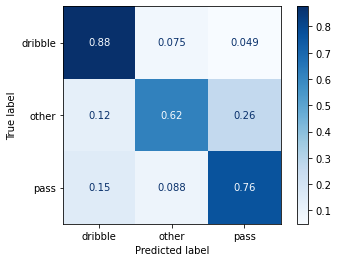

In [253]:
plot_confusion_matrix(pipe_svm, X_test, y_test, cmap='Blues', normalize='true')
plt.show()

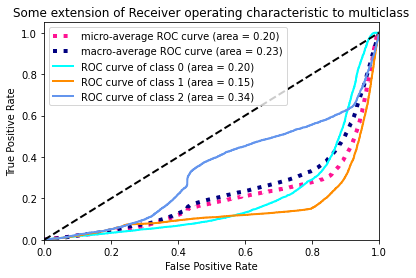

In [403]:
y_bin_test = label_binarize(y_test, classes = ['pass','dribble','other'])
n_classes = y_bin_test.shape[1]

y_score = pipe_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="best")
plt.show()

# Classification - Team - End Zone

In [384]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'end_pitch_zone')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-end')


ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))


# define column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [59]:
# Define a parameter grid
param_grid_end = [
   
     {
        'model': [RandomForestClassifier(random_state=1, oob_score=True, n_jobs=-1)],
        'model__max_depth': list(range(2, 17, 2)),
        'model__max_features': [None, 'auto'],
        'model__n_estimators': list(range(80, 150, 20))}, 
    
     {
        'model': [xgb.XGBClassifier(random_state=1)],
        'model__max_depth': list(range(2, 5, 1)),
        'model__gamma': [0, 0.1, 0.5, 0.9],
        'model__eta': [0.01, 0.1, 0.3]
        },

]

# Instantiate a gridsearch
grid_end = GridSearchCV(estimator, param_grid_end, cv = 5, verbose = 2)
fitted_grid_end = grid_end.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   6.3s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.8s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), model__max_depth=2, model__max_features=None, model__n_estimators=80; total time=   3.7s
[CV] END model=RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=1), 

In [177]:
grid_search_results_end = pd.DataFrame(fitted_grid_end.cv_results_)
grid_search_results_end.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__max_features,param_model__n_estimators,param_model__eta,param_model__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
92,30.424726,0.650538,0.033494,0.001955,"XGBClassifier(base_score=None, booster=None, c...",3,NaN,NaN,0.3,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.683054,0.684253,0.668665,0.673461,0.693046,0.680496,0.008574,1
90,35.460561,1.165587,0.029699,0.001232,"XGBClassifier(base_score=None, booster=None, c...",4,NaN,NaN,0.3,0,"{'model': XGBClassifier(base_score=None, boost...",0.692246,0.685052,0.661871,0.667466,0.695444,0.680416,0.013408,2
95,26.958471,0.399852,0.031620,0.001454,"XGBClassifier(base_score=None, booster=None, c...",3,NaN,NaN,0.3,0.5,"{'model': XGBClassifier(base_score=None, boost...",0.681055,0.680256,0.668665,0.673461,0.694644,0.679616,0.008788,3
91,19.683138,0.586587,0.032026,0.001173,"XGBClassifier(base_score=None, booster=None, c...",2,NaN,NaN,0.3,0.1,"{'model': XGBClassifier(base_score=None, boost...",0.677458,0.684652,0.667066,0.673062,0.692646,0.678977,0.008924,4
97,17.141578,0.201692,0.027977,0.001288,"XGBClassifier(base_score=None, booster=None, c...",2,NaN,NaN,0.3,0.9,"{'model': XGBClassifier(base_score=None, boost...",0.682254,0.687050,0.664668,0.674660,0.685851,0.678897,0.008325,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.209941,0.013858,0.032672,0.000936,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,auto,80,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.397282,0.417666,0.354516,0.367306,0.378497,0.383054,0.022287,96
0,4.213472,1.035617,0.034561,0.003887,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,80,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.325739,0.365308,0.271783,0.306155,0.308953,0.315588,0.030420,97
1,4.338059,0.064258,0.035688,0.000977,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,100,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.324940,0.362110,0.273381,0.305755,0.307754,0.314788,0.028941,98
2,4.997581,0.098873,0.038319,0.001049,"RandomForestClassifier(n_jobs=-1, oob_score=Tr...",2,None,120,NaN,NaN,"{'model': RandomForestClassifier(n_jobs=-1, oo...",0.325739,0.362110,0.272582,0.305356,0.306555,0.314468,0.029315,99


```Check for class imbalance for end zone in the prior notebook```

# Final Models

### FINAL VAEP MODEL:

In [404]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'vaep_value')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-vaep')

# define column transformed for pipeline
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer for GridSearchCV
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [405]:
print('*** xGBoost Regressor - Depth 8 ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=8, gamma=0.01, reg_alpha=1.1, eta=0.1))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Regressor - Depth 8 ***
XGB Regressor Train Score:  0.8406537986332749
XGB Regressor Test Score:  0.7623045325905606
 


In [406]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,type_name_shot,0.457126
1,result_name_success,0.134707
2,type_name_cross,0.043451
3,type_name_shot_freekick,0.023027
4,end_x,0.017588


### FINAL xT MODEL

In [407]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_xt_train_df, modeling_xt_test_df, 'xT_value')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-xt')

# pipeline column transformer
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define gridsearch column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [408]:
print('*** xGBoost Regressor - Depth 5 Optimised ***')
pipe = make_pipeline(ct, xgb.XGBRegressor(max_depth=5, reg_lambda=200))
pipe.fit(X_train, y_train)
print('XGB Regressor Train Score: ', pipe.score(X_train, y_train))
print('XGB Regressor Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Regressor - Depth 5 Optimised ***
XGB Regressor Train Score:  0.9265065158190492
XGB Regressor Test Score:  0.8085949010492468
 


In [409]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,type_name_cross,0.230911
1,end_pitch_zone_zone_8,0.100993
2,start_pitch_zone_zone_8,0.063345
3,x_dif,0.046887
4,end_x,0.044581


### FINAL NEXT ACTION MODEL

In [410]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'type_name_encoded')

numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-action')

ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

# define column transformer

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [411]:
print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe.fit(X_train, y_train)
print('XGB Train Score: ', pipe.score(X_train, y_train))
print('XGB Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Classifier ***
[14:23:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  0.872501998401279
XGB Test Score:  0.8036798612062275
 


In [412]:
roc_auc_score(y_test, pipe.predict_proba(X_test), multi_class='ovo')

0.9214789707522385

              precision    recall  f1-score   support

     dribble       0.80      0.91      0.85      8378
       other       0.74      0.63      0.69      4117
        pass       0.83      0.79      0.81      9408

    accuracy                           0.80     21903
   macro avg       0.79      0.78      0.78     21903
weighted avg       0.80      0.80      0.80     21903



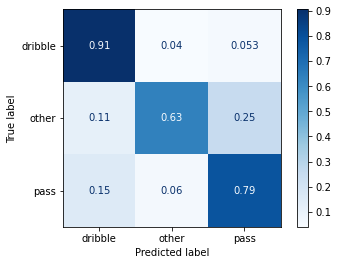

In [413]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))

plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', normalize='true')
plt.show()

In [414]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,n-1_type_name_encoded_dribble,0.199941
1,n-1_same_team_False,0.150945
2,n-1_type_name_encoded_pass,0.043632
3,n-1_result_name_success,0.040079
4,n-2_type_name_encoded_dribble,0.030164


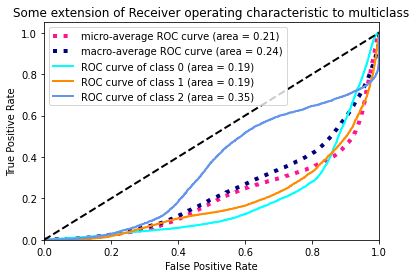

In [415]:
y_bin_test = label_binarize(y_test, classes = ['pass','dribble','other'])
n_classes = y_bin_test.shape[1]

y_score = pipe.predict_proba(X_test)
# y_score = pipe_svm.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="best")
plt.show()

### FINAL END ZONE MODEL

In [416]:
X_train, y_train, X_test, y_test = ppu.create_team_data('team_id',1475, modeling_train_df, modeling_test_df, 'end_pitch_zone')
numeric_features, categorical_features, drop_features = ppu.set_ct_mode('team-end')


ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))


# define column transformer
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features),
    ('drop', 'drop', drop_features)])

estimator = Pipeline(steps=[('preprocessor', preprocessor),
                       ('dim_reducer', PCA()),
                       ('model', LinearRegression())], memory=cachedir)

In [417]:
print('*** xGBoost Classifier ***')
pipe = make_pipeline(ct, xgb.XGBClassifier(max_depth=3, eta=0.3, gamma=0.01))
pipe.fit(X_train, y_train)
print('XGB Train Score: ', pipe.score(X_train, y_train))
print('XGB Test Score: ', pipe.score(X_test, y_test))
print(' ')

*** xGBoost Classifier ***
[14:23:34] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score:  0.8621902478017586
XGB Test Score:  0.7228690133771629
 


In [418]:
y_pred_end = pipe.predict(X_test)
y_proba_end = pipe.predict_proba(X_test)

In [419]:
roc_auc_score(y_test, y_proba_end, multi_class='ovr')

0.9625525120169188

In [420]:
print(classification_report(y_test, y_pred_end))

              precision    recall  f1-score   support

      zone_1       0.69      0.63      0.66      1589
      zone_2       0.64      0.70      0.67      2231
      zone_3       0.69      0.67      0.68      1730
      zone_4       0.74      0.76      0.75      3383
      zone_5       0.65      0.57      0.61      2486
      zone_6       0.72      0.76      0.74      3441
      zone_7       0.78      0.78      0.78      2293
      zone_8       0.79      0.73      0.76      2213
      zone_9       0.78      0.81      0.80      2537

    accuracy                           0.72     21903
   macro avg       0.72      0.71      0.72     21903
weighted avg       0.72      0.72      0.72     21903



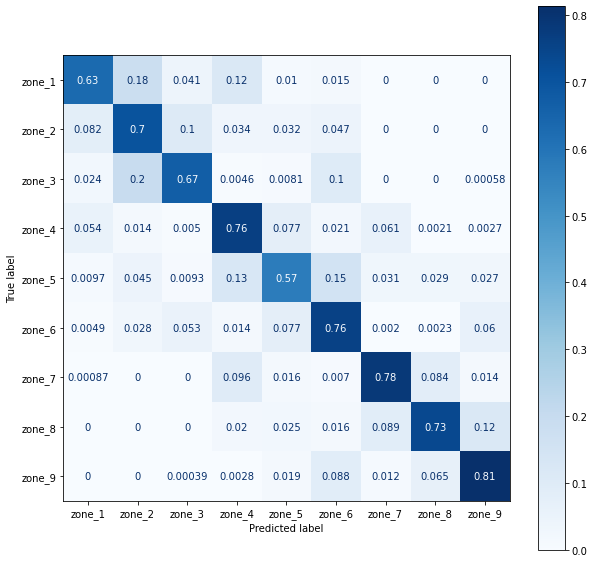

In [421]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', normalize='true', ax=ax)
plt.show()

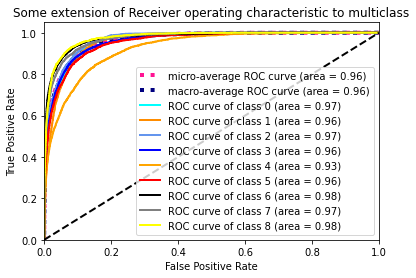

In [422]:
y_bin_test = label_binarize(y_test, classes = ['zone_1','zone_2','zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9'])
n_classes = y_bin_test.shape[1]

y_score = pipe.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "orange", "red","black", "gray", "yellow"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="best")
plt.show()

In [423]:
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
# Put the variable names and their feature importances into a data frame
importances_df = pd.DataFrame({'Variable': column_names,
                               'Importance': pipe[1].feature_importances_})

importances_df.sort_values(by='Importance', ascending=False, inplace=True, ignore_index=True)

importances_df.head(5)

,Variable,Importance
0,start_pitch_zone_zone_9,0.181271
1,start_pitch_zone_zone_7,0.114634
2,start_pitch_zone_zone_1,0.111615
3,start_pitch_zone_zone_6,0.104527
4,start_pitch_zone_zone_5,0.064072
